In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load the uploaded file
df = pd.read_csv("C:\\Users\\gnana\\\OneDrive\\Documents\\Netflix Dataset.csv")

print("--- Data Structure ---")
print(f"Shape of the dataset: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn Information (Data Types and Non-Null Counts):")
df.info()
print("\nMissing Values Count (per column):")
print(df.isnull().sum())

--- Data Structure ---
Shape of the dataset: (7789, 11)

First 5 rows:
  Show_Id Category  Title           Director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie  07:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                Cast        Country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

        Release_Date Rating   Duration  \
0    August 14, 2020  TV-MA  4 Seasons   
1  December 23, 2016  TV-MA     93 min   
2  December 20, 2018      R     78 min   
3  November 16, 2017  PG-13     80 min   
4  

In [41]:



df['Director'].fillna('Unknown', inplace=True)
df['Cast'].fillna('Unknown', inplace=True)
df['Country'].fillna('Unknown', inplace=True)

# Handle missing values: Drop rows where 'Release_Date' is missing (Crucial for time analysis)
# The previous KeyError was resolved by using the correct column name.
df.dropna(subset=['Release_Date'], inplace=True) 

# Handle missing values: Fill missing 'Rating' with the mode
df['Rating'].fillna(df['Rating'].mode()[0], inplace=True)

# Fix Column Case and Type for Analysis:
# 1. FIX THE VALUE ERROR HERE: Use 'format="mixed"' to handle inconsistent date strings.
df['Release_Date'] = pd.to_datetime(df['Release_Date'], format="mixed")
df['year_added'] = df['Release_Date'].dt.year

# 2. Rename columns to match the analysis code from previous steps
# Based on your CSV structure: 'Category' is 'type' (Movie/TV Show)
df.rename(columns={'Category': 'type'}, inplace=True) 
# Assuming 'Type' is the genre column based on the snippet:
df.rename(columns={'Type': 'listed_in'}, inplace=True)
# Rename Release_Date to date_added to match the variable name in the analysis code
df.rename(columns={'Release_Date': 'date_added'}, inplace=True)


# --- Verification of Cleaning ---
print("\n--- Verification of Cleaning ---")
print(f"New shape after dropping nulls: {df.shape}")
print(f"Date column dtype is now: {df['date_added'].dtype}")
print("Missing values check after cleaning:")
print(df[['Director', 'Cast', 'Country', 'date_added', 'Rating']].isnull().sum())


--- Verification of Cleaning ---
New shape after dropping nulls: (7779, 12)
Date column dtype is now: datetime64[ns]
Missing values check after cleaning:
Director      0
Cast          0
Country       0
date_added    0
Rating        0
dtype: int64


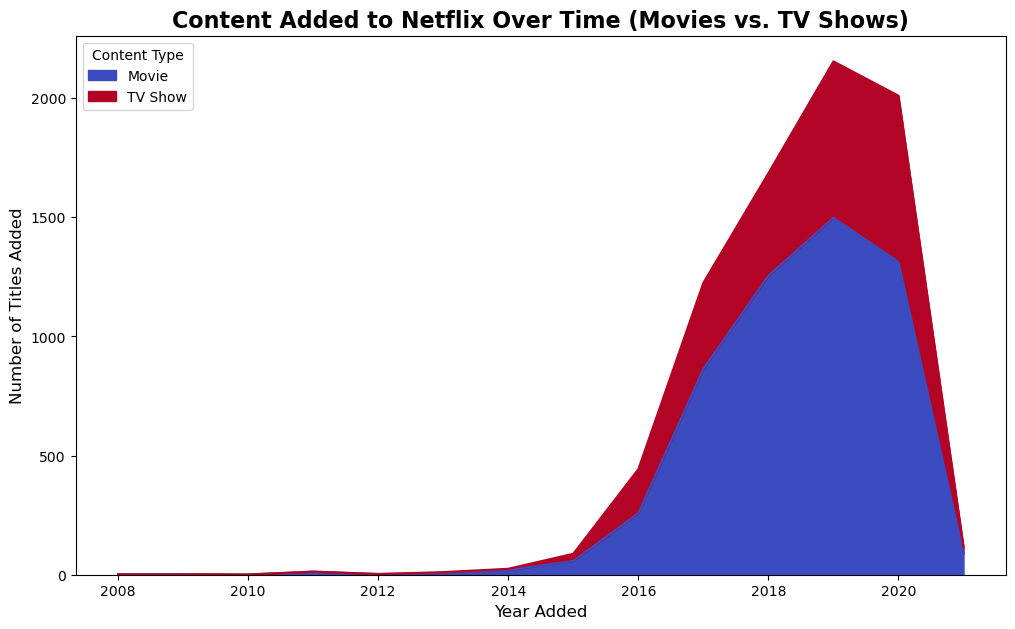

In [43]:
# Group by year added and content type, then unstack to get columns for Movie and TV Show counts
content_over_time = df.groupby('year_added')['type'].value_counts().unstack().fillna(0)

# Plotting the time-series trend of content additions (Stacked Area Chart)
plt.figure(figsize=(12, 7))
content_over_time.plot(kind='area', stacked=True, ax=plt.gca(), cmap='coolwarm')
plt.title('Content Added to Netflix Over Time (Movies vs. TV Shows)', fontsize=16, fontweight='bold')
plt.xlabel('Year Added', fontsize=12)
plt.ylabel('Number of Titles Added', fontsize=12)
plt.legend(title='Content Type')
plt.xticks(content_over_time.index[::2]) # Show every second year for cleaner x-axis
plt.show()

In [51]:
# Helper function to split and count items in multi-value columns
def split_and_count(series):
    # Split by comma and whitespace, then stack to turn into single list, and count
    split_list = series.dropna().str.split(',\s*', expand=True).stack().str.strip()
    return pd.Series(Counter(split_list)).sort_values(ascending=False)

# Get counts for Genres and Countries
genre_counts = split_and_count(df['listed_in'])
country_counts = split_and_count(df[df['Country'] != 'Unknown']['Country'])

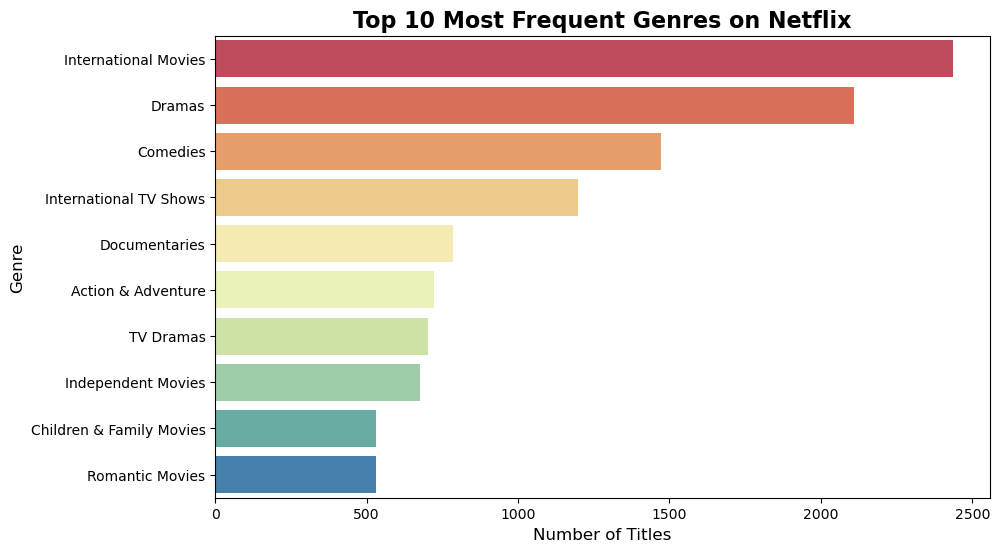

In [53]:
# Plotting Top 10 Genres
top_10_genres = genre_counts.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_genres.values, y=top_10_genres.index, palette='Spectral')
plt.title('Top 10 Most Frequent Genres on Netflix', fontsize=16, fontweight='bold')
plt.xlabel('Number of Titles', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

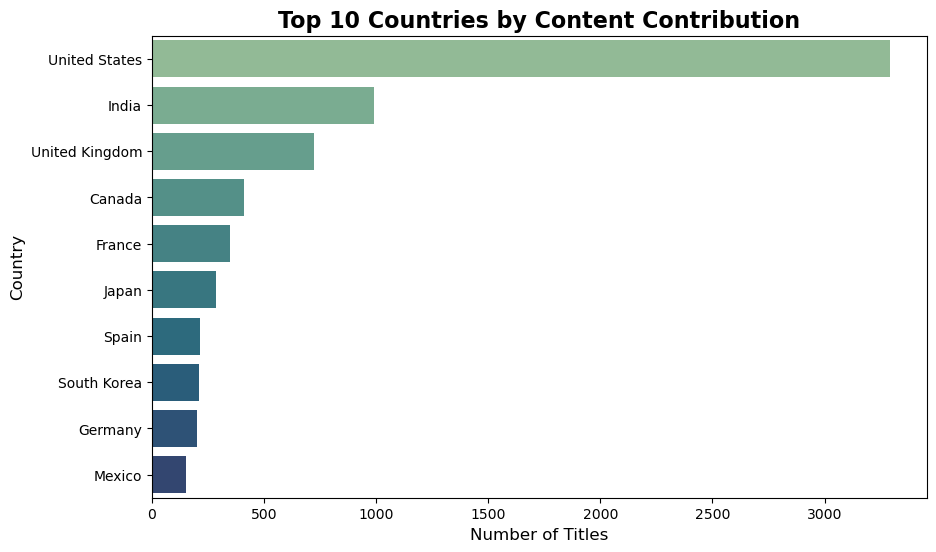

In [55]:
# Plotting Top 10 Countries (excluding 'Unknown')
top_10_countries = country_counts.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_countries.values, y=top_10_countries.index, palette='crest')
plt.title('Top 10 Countries by Content Contribution', fontsize=16, fontweight='bold')
plt.xlabel('Number of Titles', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()

Top 5 Genres for Time Series Analysis: ['International Movies', 'Dramas', 'Comedies', 'International TV Shows', 'Documentaries']


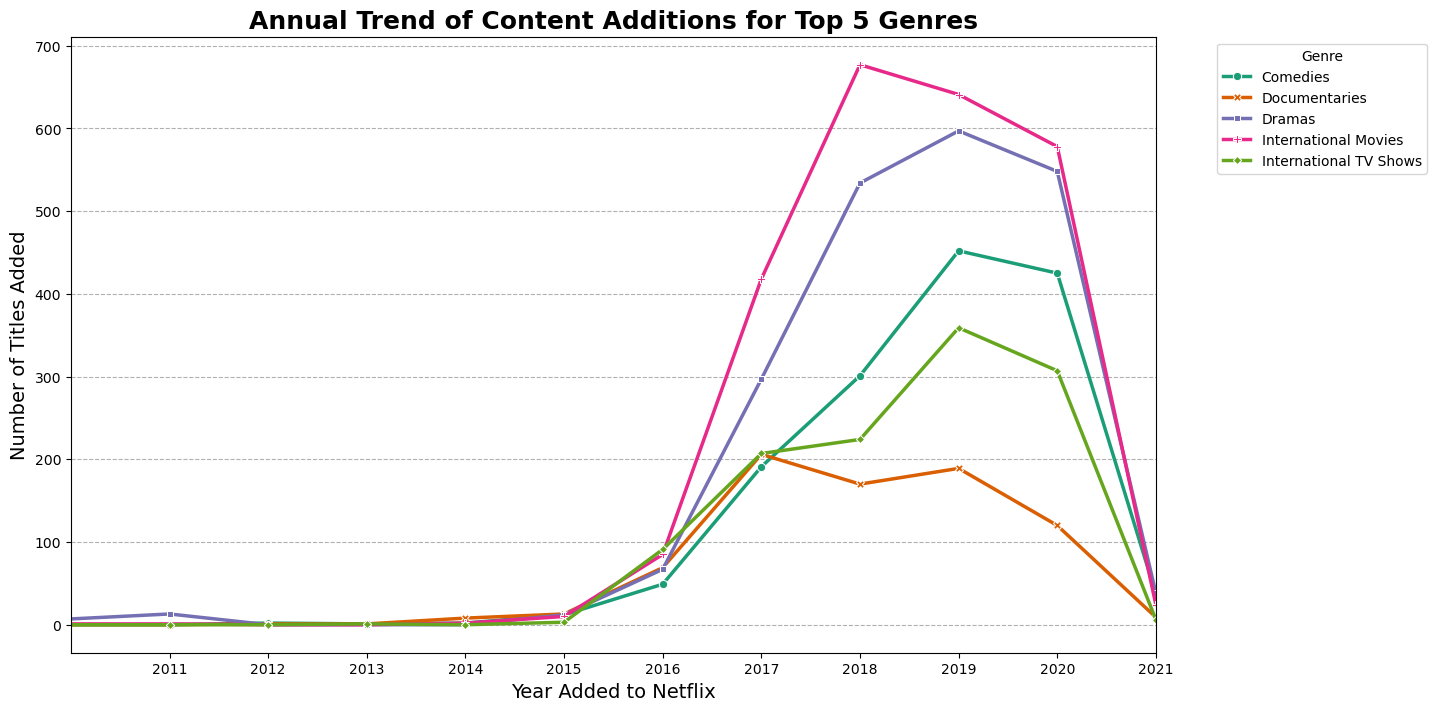

In [57]:
# Re-define the helper function and genre counts (assuming the previous code block was run)
from collections import Counter

def split_and_count(series):
    split_list = series.dropna().str.split(',\s*', expand=True).stack().str.strip()
    return pd.Series(Counter(split_list)).sort_values(ascending=False)

# Re-calculate genre counts based on the cleaned global df
genre_counts = split_and_count(df['listed_in'])

# 1. Identify the Top 5 Genres
top_5_genres = genre_counts.head(5).index.tolist()
print(f"Top 5 Genres for Time Series Analysis: {top_5_genres}")

# 2. Explode the 'listed_in' column to have one row per genre
genre_df = df.assign(listed_in=df['listed_in'].str.split(',\s*')).explode('listed_in')
genre_df['listed_in'] = genre_df['listed_in'].str.strip()

# 3. Filter for Top 5 Genres and group by year
genre_trend = genre_df[genre_df['listed_in'].isin(top_5_genres)]
genre_trend_by_year = genre_trend.groupby(['year_added', 'listed_in']).size().unstack(fill_value=0)

# 4. Plot the time series
plt.figure(figsize=(14, 8))
sns.lineplot(data=genre_trend_by_year, markers=True, dashes=False, palette='Dark2', linewidth=2.5)

plt.title('Annual Trend of Content Additions for Top 5 Genres', fontsize=18, fontweight='bold')
plt.xlabel('Year Added to Netflix', fontsize=14)
plt.ylabel('Number of Titles Added', fontsize=14)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')
plt.xticks(genre_trend_by_year.index[::1].astype(int))
plt.xlim(2010, 2021) # Focusing on the period with significant growth
plt.show()


--- Content Type Proportions for Top 5 Countries (%) ---
type            Movie  TV Show
Country                       
Canada          66.67    33.33
France          60.00    40.00
India           92.31     7.69
United Kingdom  48.74    51.26
United States   72.59    27.41


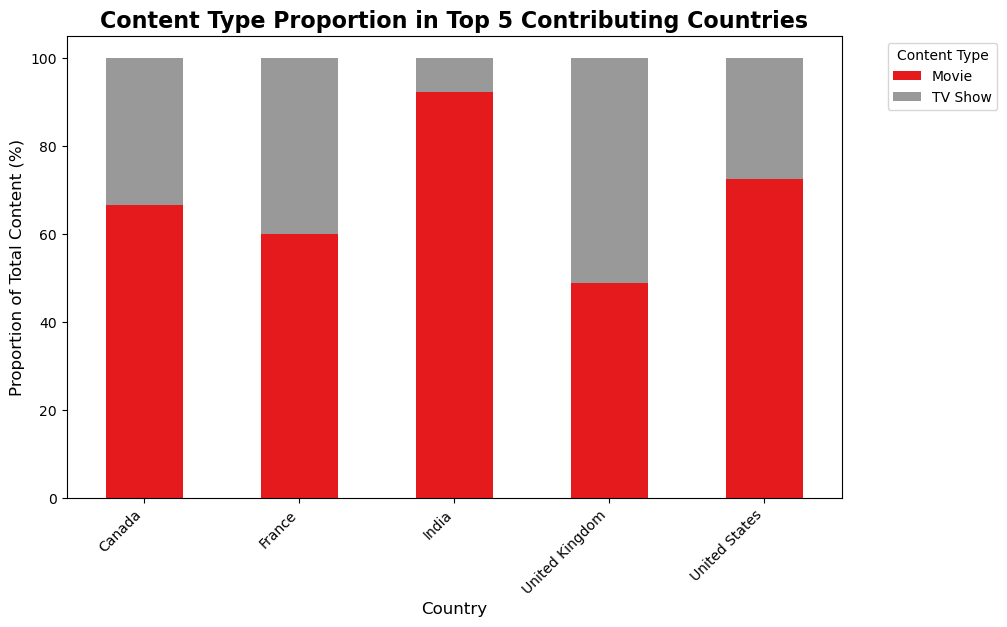

In [61]:
# Re-define the helper function and country counts (assuming the previous code block was run)
from collections import Counter

def split_and_count(series):
    split_list = series.dropna().str.split(',\s*', expand=True).stack().str.strip()
    return pd.Series(Counter(split_list)).sort_values(ascending=False)

# Get the top 5 countries (excluding 'Unknown')
country_counts = split_and_count(df[df['Country'] != 'Unknown']['Country'])
top_5_countries = country_counts.head(5).index.tolist()

# 1. Explode the 'country' column to have one row per country for each title
country_df = df.assign(country=df['Country'].str.split(',\s*')).explode('Country')
country_df['Country'] = country_df['Country'].str.strip()

# 2. Filter for the top 5 countries and calculate the breakdown by type
country_type_breakdown = country_df[country_df['Country'].isin(top_5_countries)].groupby(['Country', 'type']).size().unstack(fill_value=0)

# 3. Convert absolute counts to proportions (%) for comparison
country_type_proportions = country_type_breakdown.apply(lambda x: x / x.sum(), axis=1) * 100

print("\n--- Content Type Proportions for Top 5 Countries (%) ---")
print(country_type_proportions.round(2))

# 4. Plot the proportional breakdown
country_type_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Set1')
plt.title('Content Type Proportion in Top 5 Contributing Countries', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Proportion of Total Content (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Content Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()